# CNN Character Recognition Model - Baseline (PyTorch Version)

**Focus**: Build an interpretable, classic vision-driven model for character recognition.

## Model Architecture Intuition

This baseline CNN uses 3 convolutional layers to progressively learn character features:

### Layer-by-Layer Feature Detection:

**Layer 1 (32 filters, 3×3 kernels)**:
- Detects **low-level features**: edges, gradients, simple textures
- Identifies basic strokes (horizontal, vertical, diagonal lines)
- These are the building blocks of all characters

**Layer 2 (64 filters, 3×3 kernels)**:
- Detects **mid-level features**: corners, junctions, curves
- Combines edges to form simple shapes (circles, arcs, angles)
- Recognizes stroke patterns and intersections

**Layer 3 (128 filters, 3×3 kernels)**:
- Detects **high-level features**: character-specific parts
- Identifies loops (0, 6, 8, 9, a, b, d, g, o, p, q)
- Recognizes stems, crossbars, ascenders, descenders
- Combines mid-level features into complete character patterns

### Design Choices:
- **3×3 kernels**: Standard for capturing local spatial patterns
- **MaxPooling (2×2)**: Reduces spatial dimensions, creates translation invariance
- **BatchNormalization**: Stabilizes training, enables higher learning rates
- **Dropout (0.5)**: Regularization to prevent overfitting
- **Total params**: ~235K (lightweight, interpretable)

## Workflow:
1. Load training/test data (36 classes: 0-9, a-z)
2. Train small CNN on full training set
3. Evaluate on test set with detailed metrics
4. Analyze overfitting/underfitting
5. Save baseline model and results

## Import Libraries

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cpu
Using device: cpu


## Configuration

In [11]:
# Paths
TRAIN_DATA_DIR = Path('../Segmented_dataset/train_characters')
TEST_DATA_DIR = Path('../Segmented_dataset/test_characters')
MODEL_SAVE_DIR = Path('../models/saved_models')

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMAGE_SIZE = 32
NUM_CLASSES = 36  # 0-9, a-z

# Character mapping
CHARACTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHARACTERS)}
IDX_TO_CHAR = {idx: char for char, idx in CHAR_TO_IDX.items()}

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data Loading (with Cache)


In [12]:
# Cache configuration
CACHE_DIR = Path('../Segmented_dataset/cache')
CACHE_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_CACHE = CACHE_DIR / 'train_data.npz'
TEST_CACHE = CACHE_DIR / 'test_data.npz'

def save_data_cache(X, y, filenames, cache_path):
    """Save preprocessed data to disk"""
    np.savez_compressed(cache_path, 
                       X=X, 
                       y=y, 
                       filenames=filenames if filenames else [])
    print(f"Saved cache: {cache_path} ({cache_path.stat().st_size / 1024 / 1024:.1f} MB)")

def load_data_cache(cache_path):
    """Load preprocessed data from disk"""
    data = np.load(cache_path, allow_pickle=True)
    filenames = data['filenames'].tolist() if len(data['filenames']) > 0 else None
    print(f"Loaded from cache: {cache_path}")
    return data['X'], data['y'], filenames


## Load Training and Test Data

In [13]:
# Try to load from cache, otherwise load from images

def load_data(data_dir, name="Data", return_filenames=False):
    """
    Load character images and labels.
    
    Args:
        data_dir: Path to directory containing character folders
        name: Name for logging
        return_filenames: If True, also return filenames for string-level accuracy
    
    Returns:
        If return_filenames=False: (images, labels)
        If return_filenames=True: (images, labels, filenames)
    """
    data_dir = Path(data_dir)
    
    if not data_dir.exists():
        print(f"ERROR: Directory does not exist: {data_dir}")
        if return_filenames:
            return np.array([]), np.array([]), []
        else:
            return np.array([]), np.array([])
    
    images = []
    labels = []
    filenames = []
    
    print(f"Loading {name}...")
    for char_folder in sorted(data_dir.iterdir()):
        if char_folder.is_dir() and char_folder.name in CHARACTERS:
            label = CHAR_TO_IDX[char_folder.name]
            png_files = list(char_folder.glob('*.png'))
            print(f"  {char_folder.name}: {len(png_files)} files")
            
            for img_file in png_files:
                image = cv2.imread(str(img_file))
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    images.append(image)
                    labels.append(label)
                    if return_filenames:
                        filenames.append(img_file.name)
    
    print(f"Total: {len(images)} samples\n")
    
    if return_filenames:
        return np.array(images), np.array(labels), filenames
    else:
        return np.array(images), np.array(labels)
        
# Load training data
if TRAIN_CACHE.exists():
    print("Loading training data from cache (fast)...")
    X_train, y_train, _ = load_data_cache(TRAIN_CACHE)
else:
    print("Loading training data from images (first time, slow)...")
    X_train, y_train = load_data(TRAIN_DATA_DIR, "Training Data", return_filenames=False)
    save_data_cache(X_train, y_train, None, TRAIN_CACHE)

# Load test data
if TEST_CACHE.exists():
    print("Loading test data from cache (fast)...")
    X_test, y_test, test_filenames = load_data_cache(TEST_CACHE)
else:
    print("Loading test data from images (first time, slow)...")
    X_test, y_test, test_filenames = load_data(TEST_DATA_DIR, "Test Data", return_filenames=True)
    save_data_cache(X_test, y_test, test_filenames, TEST_CACHE)

# NOTE: We do NOT convert to categorical (one-hot) for PyTorch's CrossEntropyLoss.
# It expects class indices (which y_train and y_test already are).

# Summary
print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"  Training:   {len(X_train):,} samples")
print(f"  Test:       {len(X_test):,} samples")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}x3")
print(f"  Classes:    {NUM_CLASSES}")
print(f"{'='*60}")
print("Data ready for processing")

Loading training data from cache (fast)...
Loaded from cache: ..\Segmented_dataset\cache\train_data.npz
Loading test data from cache (fast)...
Loaded from cache: ..\Segmented_dataset\cache\test_data.npz

DATASET SUMMARY
  Training:   46,244 samples
  Test:       9,280 samples
  Image size: 32x32x3
  Classes:    36
Data ready for processing
Loading test data from cache (fast)...
Loaded from cache: ..\Segmented_dataset\cache\test_data.npz

DATASET SUMMARY
  Training:   46,244 samples
  Test:       9,280 samples
  Image size: 32x32x3
  Classes:    36
Data ready for processing


## Split Training and Validation Sets

In [14]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

# Labels (y_train_split, y_val) remain as class indices (long integers)

print(f"\n{'='*60}")
print(f"DATA SPLIT SUMMARY")
print(f"{'='*60}")
print(f"  Training:   {len(X_train_split):,} samples ({len(X_train_split)/len(X_train)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X_train)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples")
print(f"{'='*60}")
print("✓ Data split completed")


DATA SPLIT SUMMARY
  Training:   41,619 samples (90.0%)
  Validation: 4,625 samples (10.0%)
  Test:       9,280 samples
✓ Data split completed


## Create PyTorch DataLoaders

We convert the NumPy arrays to PyTorch Tensors. Crucially, we must permute the image dimensions from (N, H, W, C) [Keras/NumPy default] to (N, C, H, W) [PyTorch default].

In [15]:
# Convert to Tensors and permute dimensions (N, H, W, C) -> (N, C, H, W)
X_train_tensor = torch.tensor(X_train_split).permute(0, 3, 1, 2).float()
y_train_tensor = torch.tensor(y_train_split).long() 
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float()
y_val_tensor = torch.tensor(y_val).long()
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2).float()
y_test_tensor = torch.tensor(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch DataLoaders created.")
print(f"Train tensor shape: {X_train_tensor.shape}")
print(f"Test tensor shape: {X_test_tensor.shape}")

PyTorch DataLoaders created.
Train tensor shape: torch.Size([41619, 3, 32, 32])
Test tensor shape: torch.Size([9280, 3, 32, 32])


## Model Definition

In [16]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        """
        Create a 3-layer CNN for character recognition.
        
        Architecture reasoning:
        - Layer 1: Detects edges and basic strokes
        - Layer 2: Detects corners and simple shapes
        - Layer 3: Detects character-specific features
        """
        super(CNNModel, self).__init__()
        
        # Input shape (N, 3, 32, 32)
        self.conv1 = nn.Sequential(
            # Keras: Conv2D(32, (3, 3), 'relu') -> (N, 30, 30, 32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Keras: MaxPooling2D((2, 2)) -> (N, 15, 15, 32)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            # Keras: Conv2D(64, (3, 3), 'relu') -> (N, 13, 13, 64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Keras: MaxPooling2D((2, 2)) -> (N, 6, 6, 64)
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.conv3 = nn.Sequential(
            # Keras: Conv2D(128, (3, 3), 'relu') -> (N, 4, 4, 128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Keras: MaxPooling2D((2, 2)) -> (N, 2, 2, 128)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            # Keras: Flatten() -> (N, 512)
            nn.Linear(128 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
            # Note: No Softmax, as CrossEntropyLoss expects raw logits
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Create model and move to device
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model Architecture:")
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
           Linear-1

## Training Setup

In [17]:
# Setup learning rate scheduler (equivalent to Keras ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',          # 'min' because we monitor val_loss
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Setup for Early Stopping (will be implemented in the training loop)
EARLY_STOP_PATIENCE = 12
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = MODEL_SAVE_DIR / 'best_baseline_cnn.pth'

print(f"Scheduler and Early Stopping (Patience={EARLY_STOP_PATIENCE}) configured.")
print(f"Best model will be saved to: {BEST_MODEL_PATH}")

Scheduler and Early Stopping (Patience=12) configured.
Best model will be saved to: ..\models\saved_models\best_baseline_cnn.pth


## Train Model

In [18]:
print("Starting training...")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}\n")

start_time = time.time()

# To store history
history = {
    'loss': [], 
    'accuracy': [], 
    'val_loss': [], 
    'val_accuracy': []
}

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    
    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)
    
    # --- Epoch End ---
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | ' 
          f'Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} | ' 
          f'Val_Loss: {epoch_val_loss:.4f} - Val_Acc: {epoch_val_acc:.4f} | ' 
          f'LR: {optimizer.param_groups[0]["lr"]:.1e}')
    
    # Scheduler step
    scheduler.step(epoch_val_loss)
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        # print(f'  (New best model saved to {BEST_MODEL_PATH})')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {patience_counter} epochs with no improvement.")
            break

training_time = time.time() - start_time

# Restore best model weights
print(f"Restoring model weights from the end of the best epoch: {best_epoch + 1}")
model.load_state_dict(torch.load(BEST_MODEL_PATH))

print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"  Final training accuracy (from history): {history['accuracy'][-1]:.4f}")
print(f"  Final validation accuracy (from history): {history['val_accuracy'][-1]:.4f}")
print(f"  Best validation loss (restored): {best_val_loss:.4f}")

Starting training...
  Training samples: 41,619
  Validation samples: 4,625
  Epochs: 20
  Batch size: 32

Epoch 1/20 | Loss: 1.9683 - Acc: 0.4326 | Val_Loss: 1.2217 - Val_Acc: 0.6387 | LR: 1.0e-03
Epoch 1/20 | Loss: 1.9683 - Acc: 0.4326 | Val_Loss: 1.2217 - Val_Acc: 0.6387 | LR: 1.0e-03
Epoch 2/20 | Loss: 1.3221 - Acc: 0.6016 | Val_Loss: 1.4125 - Val_Acc: 0.6069 | LR: 1.0e-03
Epoch 2/20 | Loss: 1.3221 - Acc: 0.6016 | Val_Loss: 1.4125 - Val_Acc: 0.6069 | LR: 1.0e-03
Epoch 3/20 | Loss: 1.1616 - Acc: 0.6443 | Val_Loss: 0.9276 - Val_Acc: 0.7219 | LR: 1.0e-03
Epoch 3/20 | Loss: 1.1616 - Acc: 0.6443 | Val_Loss: 0.9276 - Val_Acc: 0.7219 | LR: 1.0e-03
Epoch 4/20 | Loss: 1.0642 - Acc: 0.6749 | Val_Loss: 0.9228 - Val_Acc: 0.7215 | LR: 1.0e-03
Epoch 4/20 | Loss: 1.0642 - Acc: 0.6749 | Val_Loss: 0.9228 - Val_Acc: 0.7215 | LR: 1.0e-03
Epoch 5/20 | Loss: 0.9860 - Acc: 0.6946 | Val_Loss: 0.8695 - Val_Acc: 0.7347 | LR: 1.0e-03
Epoch 5/20 | Loss: 0.9860 - Acc: 0.6946 | Val_Loss: 0.8695 - Val_Acc: 0.73

## Helper Functions for Evaluation
(This function is pure Python/NumPy and requires no changes)

In [19]:
def calculate_string_accuracy(y_pred, y_test, filenames, idx_to_char):
    """
    Calculate string-level (complete CAPTCHA) accuracy.
    
    Returns: (string_accuracy, correct, total, captcha_pred, captcha_true, stats)
    """
    from collections import defaultdict
    
    captcha_pred = defaultdict(dict)
    captcha_true = defaultdict(dict)
    skipped = 0
    
    # Group characters by CAPTCHA ID
    for i, filename in enumerate(filenames):
        parts = filename.split('_')
        if len(parts) >= 3:
            last_part = parts[-1].replace('.png', '')
            if '-' in last_part:
                captcha_id, pos = last_part.rsplit('-', 1)
                pos = int(pos)
                captcha_pred[captcha_id][pos] = idx_to_char[y_pred[i]]
                captcha_true[captcha_id][pos] = idx_to_char[y_test[i]]
            else:
                skipped += 1
        else:
            skipped += 1
    
    # Calculate accuracy
    correct = sum(1 for cid in captcha_pred 
                  if ''.join(captcha_pred[cid][p] for p in sorted(captcha_pred[cid].keys())) == 
                     ''.join(captcha_true[cid][p] for p in sorted(captcha_true[cid].keys())))
    
    accuracy = correct / len(captcha_pred) if captcha_pred else 0
    
    # Statistics
    stats = {
        'total_chars': len(filenames),
        'parsed_chars': sum(len(captcha_pred[cid]) for cid in captcha_pred),
        'skipped_chars': skipped,
        'captchas': len(captcha_pred),
        'avg_chars_per_captcha': sum(len(captcha_pred[cid]) for cid in captcha_pred) / len(captcha_pred) if captcha_pred else 0
    }
    
    return accuracy, correct, len(captcha_pred), captcha_pred, captcha_true, stats


## Evaluate on Test Set (Character & String Level)

In [20]:
# Evaluate on test set
model.eval()
test_loss_val = 0.0
correct_test = 0
total_test = 0

y_pred_list = []
y_pred_proba_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss_val += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        # Store predictions and probabilities (after softmax) for later analysis
        y_pred_list.append(predicted.cpu().numpy())
        y_pred_proba_list.append(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate final test metrics
test_loss = test_loss_val / len(test_dataset)
test_accuracy = correct_test / total_test

# Concatenate all batch predictions into single NumPy arrays
y_pred = np.concatenate(y_pred_list)
y_pred_proba = np.concatenate(y_pred_proba_list)
# y_test is already the correct NumPy array from the initial data load

# Calculate string-level accuracy
string_accuracy, correct_captchas, total_captchas, captcha_predictions, captcha_ground_truth, stats = \
    calculate_string_accuracy(y_pred, y_test, test_filenames, IDX_TO_CHAR)

# Display results
print(f"\n{'='*60}")
print(f"ACCURACY SUMMARY")
print(f"{'='*60}")
print(f"Character Level:")
print(f"  Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Correct: {correct_test:,}/{total_test:,} characters")
print(f"\nString Level (Complete CAPTCHA):")
print(f"  Accuracy: {string_accuracy:.4f} ({string_accuracy*100:.2f}%)")
print(f"  Correct: {correct_captchas:,}/{total_captchas:,} CAPTCHAs")
print(f"  Avg chars/CAPTCHA: {stats['avg_chars_per_captcha']:.2f}")
print(f"{'='*60}")


ACCURACY SUMMARY
Character Level:
  Loss: 0.5182 | Accuracy: 0.8370 (83.70%)
  Correct: 7,767/9,280 characters

String Level (Complete CAPTCHA):
  Accuracy: 0.4339 (43.39%)
  Correct: 676/1,558 CAPTCHAs
  Avg chars/CAPTCHA: 5.96


## Training Curve Visualization
(This cell is unchanged as it plots from the `history` dictionary)

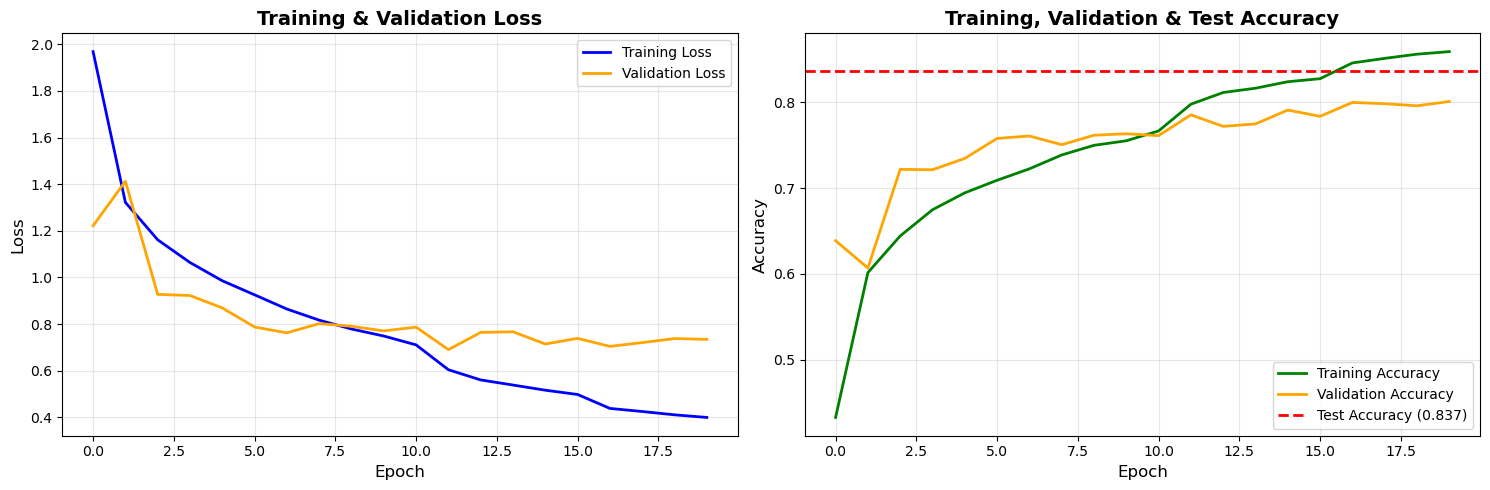


OVERFITTING ANALYSIS
Train: 0.8593 (85.93%)
Val:   0.8011 (80.11%)
Test:  0.8370 (83.70%)

Train-Val Gap:  0.0582 (5.82%)
Val-Test Gap:   -0.0359 (-3.59%)

MODERATE OVERFITTING (train-val gap 5-15%)


In [21]:
# Plot training history with analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(history['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
ax2.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
ax2.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_accuracy:.3f})')
ax2.set_title('Training, Validation & Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze overfitting/underfitting
train_acc_final = history['accuracy'][-1]
val_acc_final = history['val_accuracy'][-1]
train_val_gap = train_acc_final - val_acc_final
val_test_gap = val_acc_final - test_accuracy

print(f"\n{'='*60}")
print(f"OVERFITTING ANALYSIS")
print(f"{'='*60}")
print(f"Train: {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
print(f"Val:   {val_acc_final:.4f} ({val_acc_final*100:.2f}%)")
print(f"Test:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nTrain-Val Gap:  {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")
print(f"Val-Test Gap:   {val_test_gap:.4f} ({val_test_gap*100:.2f}%)")

if train_val_gap > 0.15:
    print(f"\nSEVERE OVERFITTING (train-val gap > 15%)")
elif train_val_gap > 0.05:
    print(f"\nMODERATE OVERFITTING (train-val gap 5-15%)")
else:
    print(f"\nGOOD GENERALIZATION (train-val gap < 5%)")

if train_acc_final < 0.7:
    print(f"\nUNDERFITTING (train < 70%)")

print(f"{'='*60}")

## Confusion Matrix & Classification Report
(This cell is unchanged as it uses the NumPy `y_test` and `y_pred` arrays)

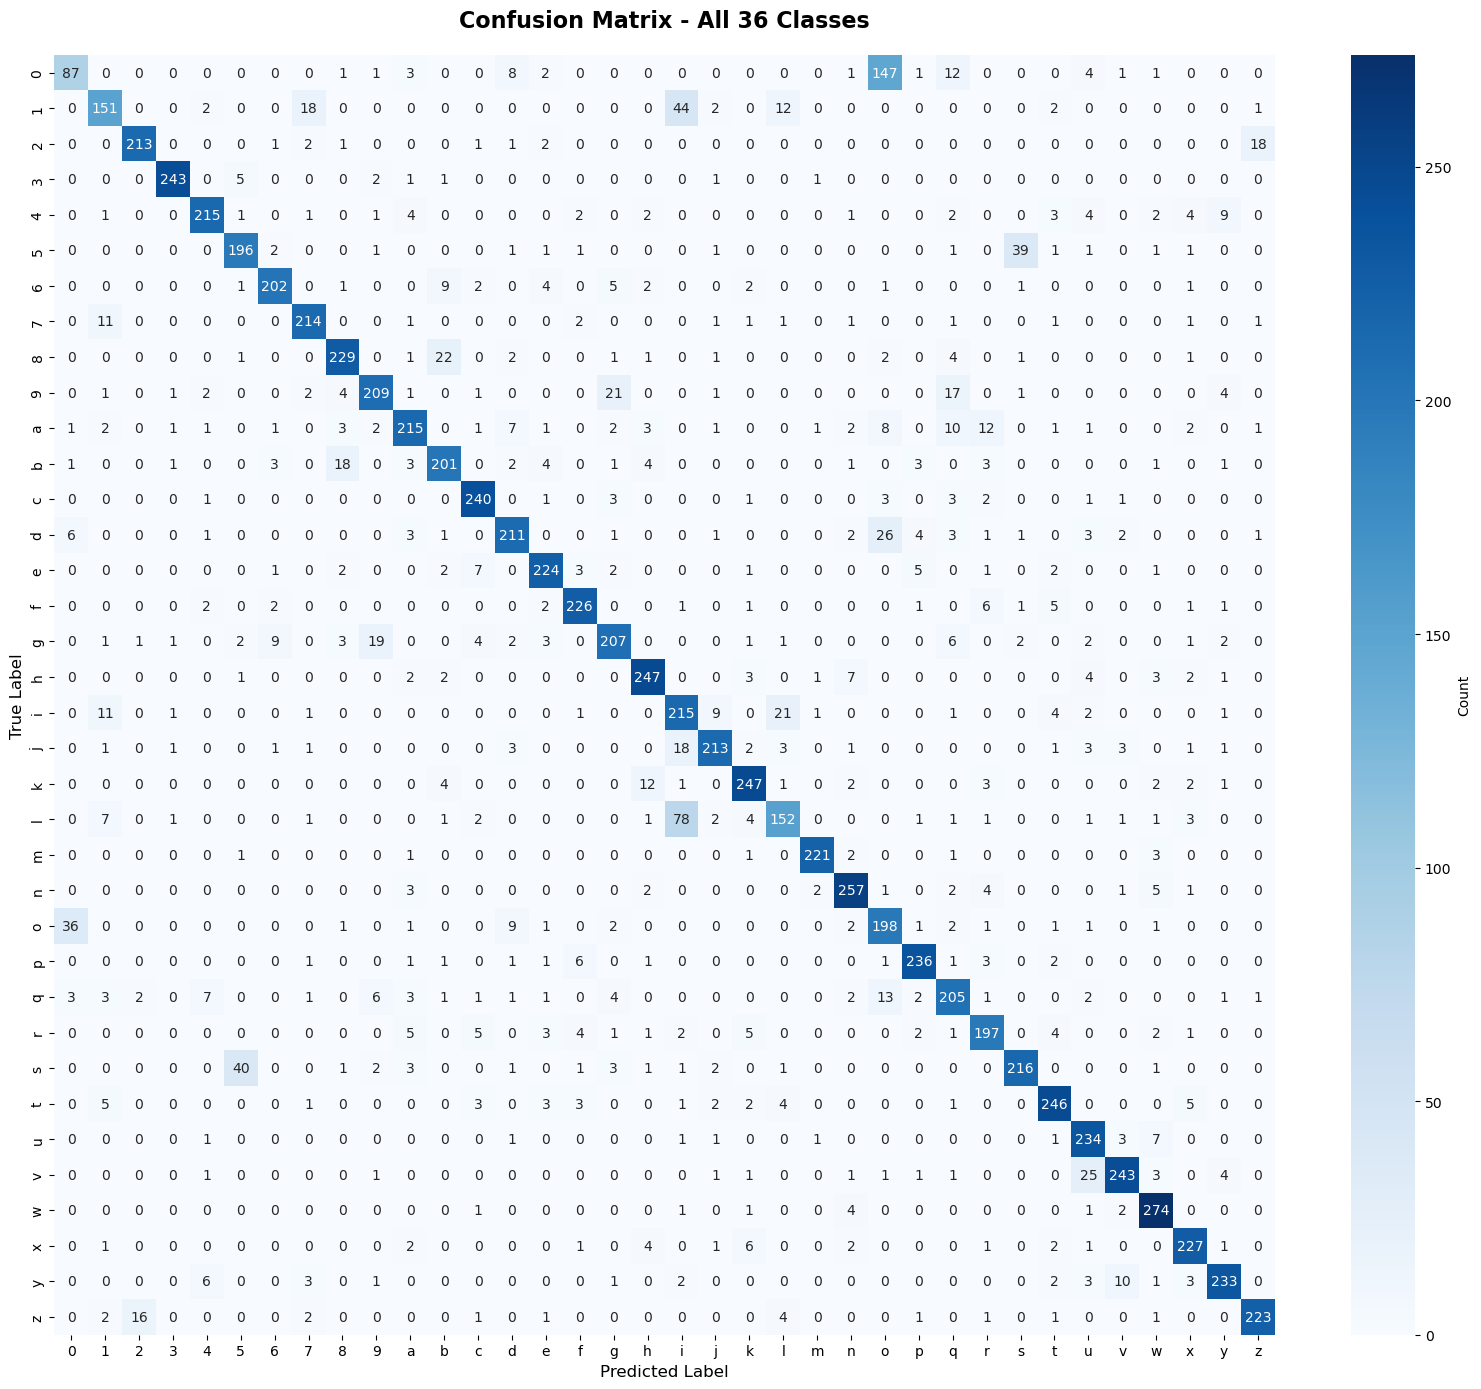


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.65      0.32      0.43       269
           1       0.77      0.65      0.70       232
           2       0.92      0.89      0.90       239
           3       0.97      0.96      0.96       254
           4       0.90      0.85      0.88       252
           5       0.79      0.79      0.79       247
           6       0.91      0.87      0.89       231
           7       0.86      0.91      0.88       236
           8       0.87      0.86      0.86       266
           9       0.85      0.79      0.82       265
           a       0.85      0.77      0.81       279
           b       0.82      0.81      0.82       247
           c       0.89      0.94      0.91       256
           d       0.84      0.79      0.82       267
           e       0.88      0.89      0.89       251
           f       0.90      0.91      0.91       249
           g       0.81      0.78      0.79       267
    

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix (all 36 classes)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CHARACTERS, yticklabels=CHARACTERS,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - All 36 Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_test, y_pred, target_names=CHARACTERS, zero_division=0)
print(report)

# Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, char in enumerate(CHARACTERS):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        print(f"  {char}: {acc:.4f} ({acc*100:.2f}%) - {mask.sum()} samples")

print("="*60)


## Sample Predictions Visualization
(This cell is unchanged as it uses the original NumPy `X_test` for plotting and the `y_pred` / `y_pred_proba` arrays)

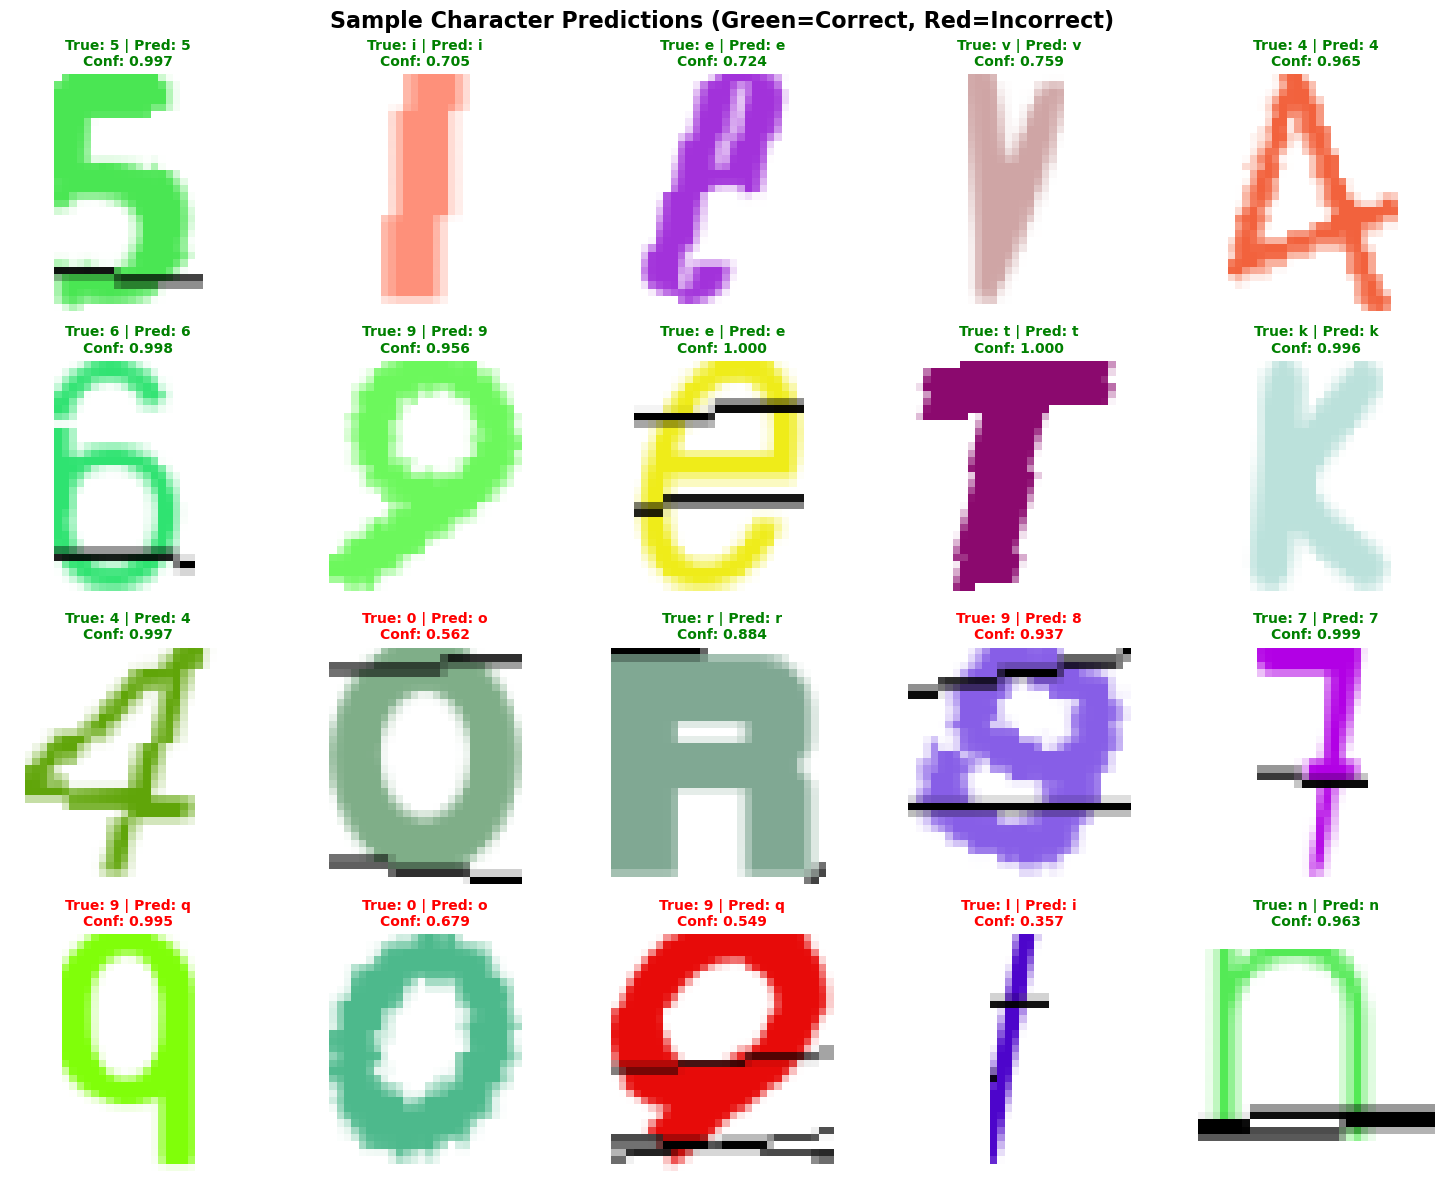

Sample character predictions displayed

SAMPLE COMPLETE CAPTCHA PREDICTIONS
  002e23-0: True=002e23 | Pred=002e23 | CORRECT
  03yl9s-0: True=03yl9s | Pred=03yi9s | WRONG
  03yuav5-0: True=03yuav5 | Pred=o3yudv5 | WRONG
  03zl9o-0: True=03zl9o | Pred=03zl9d | WRONG
  05htm-0: True=05htm | Pred=05htm | CORRECT
  05pb-0: True=05pb | Pred=o5pb | WRONG
  07oj-0: True=07oj | Pred=070j | WRONG
  07z0-0: True=07z0 | Pred=01zo | WRONG
  08ft2e2z-0: True=08ft2e2z | Pred=q8ft2e2z | WRONG
  08nxd77-0: True=08nxd77 | Pred=08nxd77 | CORRECT


In [23]:
# Show sample predictions
num_samples = 20
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    # We use the original X_test (H, W, C) for plotting with imshow
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    confidence = y_pred_proba[idx][pred_label]
    
    true_char = IDX_TO_CHAR[true_label]
    pred_char = IDX_TO_CHAR[pred_label]
    
    # Determine color
    color = 'green' if true_label == pred_label else 'red'
    
    # Plot
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_char} | Pred: {pred_char}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Character Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Sample character predictions displayed")

# Show complete CAPTCHA predictions (string-level)
print(f"\n{'='*60}")
print(f"SAMPLE COMPLETE CAPTCHA PREDICTIONS")
print(f"{'='*60}")

for captcha_id in list(captcha_predictions.keys())[:10]:
    pred_str = ''.join([captcha_predictions[captcha_id][p] for p in sorted(captcha_predictions[captcha_id].keys())])
    true_str = ''.join([captcha_ground_truth[captcha_id][p] for p in sorted(captcha_ground_truth[captcha_id].keys())])
    status = "CORRECT" if pred_str == true_str else "WRONG"
    print(f"  {captcha_id}: True={true_str} | Pred={pred_str} | {status}")

print(f"{'='*60}")

## Save Model
(We save the `state_dict` of the best model, which was loaded after training)

In [24]:
# Save model state_dict
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODEL_SAVE_DIR / 'cnn_character_recognition.pth'
torch.save(model.state_dict(), model_path)
print(f"Model state_dict saved to: {model_path}")

# Note: The 'best' model weights from early stopping are already saved at:
print(f"Best model (from early stopping) is at: {BEST_MODEL_PATH}")

Model state_dict saved to: ..\models\saved_models\cnn_character_recognition.pth
Best model (from early stopping) is at: ..\models\saved_models\best_baseline_cnn.pth


# Improved Method

1. we first use an Autoencoder to perform resonstruction mission on the dataset to learn to extract the high level representations of data. Our encoder has similar architecture compared with baseline model (for a fair comparision).

2. Then we finetune the encoder appended a classifier to perform the classification.

3. We also use some tricks including data augmentation and cosine lr scheduler to further improve the performance.

In [25]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Encoder, self).__init__()
        # Input: (N, 3, 32, 32)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2) # -> (N, 32, 16, 16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2) # -> (N, 64, 8, 8)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2) # -> (N, 128, 4, 4)
        )
        self.flatten = nn.Flatten()
        # Bottleneck
        self.fc_bottleneck = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc_bottleneck(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Decoder, self).__init__()
        self.fc_unbottleneck = nn.Linear(latent_dim, 128 * 4 * 4)
        
        # Un-Flatten -> (N, 128, 4, 4)
        self.deconv1 = nn.Sequential(
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64)
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # -> (N, 64, 8, 8)
            nn.ReLU(), nn.BatchNorm2d(64)
        )
        self.deconv2 = nn.Sequential(
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32)
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # -> (N, 32, 16, 16)
            nn.ReLU(), nn.BatchNorm2d(32)
        )
        self.deconv3 = nn.Sequential(
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid() # Sigmoid, da Eingabebilder 0-1 sind
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), # -> (N, 3, 32, 32)
            nn.Sigmoid() # Sigmoid, da Eingabebilder 0-1 sind
        )

    def forward(self, x):
        x = self.fc_unbottleneck(x)
        x = x.view(-1, 128, 4, 4) # Un-flatten
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [26]:
AE_EPOCHS = 20 
LATENT_DIM = 64

autoencoder = Autoencoder(latent_dim=LATENT_DIM).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
scheduler_ae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, 'min', patience=3, factor=0.5)

print(f"Start Autoencoder-Training for {AE_EPOCHS} Epoch...")
start_time_ae = time.time()

best_ae_loss = float('inf')

for epoch in range(AE_EPOCHS):
    # --- AE Training ---
    autoencoder.train()
    running_loss_ae = 0.0
    for inputs, _ in train_loader: 
        inputs = inputs.to(device)
        
        optimizer_ae.zero_grad()
        reconstructed = autoencoder(inputs)
        loss = criterion_ae(reconstructed, inputs)
        loss.backward()
        optimizer_ae.step()
        
        running_loss_ae += loss.item() * inputs.size(0)
    
    epoch_loss_ae = running_loss_ae / len(train_dataset)

    # --- AE Validation ---
    autoencoder.eval()
    running_val_loss_ae = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            reconstructed = autoencoder(inputs)
            loss = criterion_ae(reconstructed, inputs)
            running_val_loss_ae += loss.item() * inputs.size(0)
            
    epoch_val_loss_ae = running_val_loss_ae / len(val_dataset)
    
    print(f"AE Epoch {epoch+1}/{AE_EPOCHS} | Train Loss: {epoch_loss_ae:.6f} | Val Loss: {epoch_val_loss_ae:.6f}")
    
    scheduler_ae.step(epoch_val_loss_ae)
    
    if epoch_val_loss_ae < best_ae_loss:
        best_ae_loss = epoch_val_loss_ae
        torch.save(autoencoder.state_dict(), MODEL_SAVE_DIR / 'best_autoencoder.pth')


print(f"Bester AE Validation Loss: {best_ae_loss:.6f}")


pretrained_encoder = Encoder(latent_dim=LATENT_DIM)
pretrained_ae_state_dict = torch.load(MODEL_SAVE_DIR / 'best_autoencoder.pth')
encoder_state_dict = {k: v for k, v in pretrained_ae_state_dict.items() if k.startswith('encoder.')}

encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_state_dict.items()}
pretrained_encoder.load_state_dict(encoder_state_dict)

print("Pre-trainierter Encoder extrahiert.")

Start Autoencoder-Training for 20 Epoch...
AE Epoch 1/20 | Train Loss: 0.032879 | Val Loss: 0.019480
AE Epoch 1/20 | Train Loss: 0.032879 | Val Loss: 0.019480
AE Epoch 2/20 | Train Loss: 0.018819 | Val Loss: 0.022806
AE Epoch 2/20 | Train Loss: 0.018819 | Val Loss: 0.022806
AE Epoch 3/20 | Train Loss: 0.017805 | Val Loss: 0.015605
AE Epoch 3/20 | Train Loss: 0.017805 | Val Loss: 0.015605
AE Epoch 4/20 | Train Loss: 0.012229 | Val Loss: 0.010226
AE Epoch 4/20 | Train Loss: 0.012229 | Val Loss: 0.010226
AE Epoch 5/20 | Train Loss: 0.010242 | Val Loss: 0.009017
AE Epoch 5/20 | Train Loss: 0.010242 | Val Loss: 0.009017
AE Epoch 6/20 | Train Loss: 0.009409 | Val Loss: 0.008461
AE Epoch 7/20 | Train Loss: 0.009207 | Val Loss: 0.008092
AE Epoch 8/20 | Train Loss: 0.008507 | Val Loss: 0.007528
AE Epoch 9/20 | Train Loss: 0.008015 | Val Loss: 0.007267
AE Epoch 10/20 | Train Loss: 0.007506 | Val Loss: 0.007374
AE Epoch 11/20 | Train Loss: 0.007182 | Val Loss: 0.006723
AE Epoch 12/20 | Train Loss

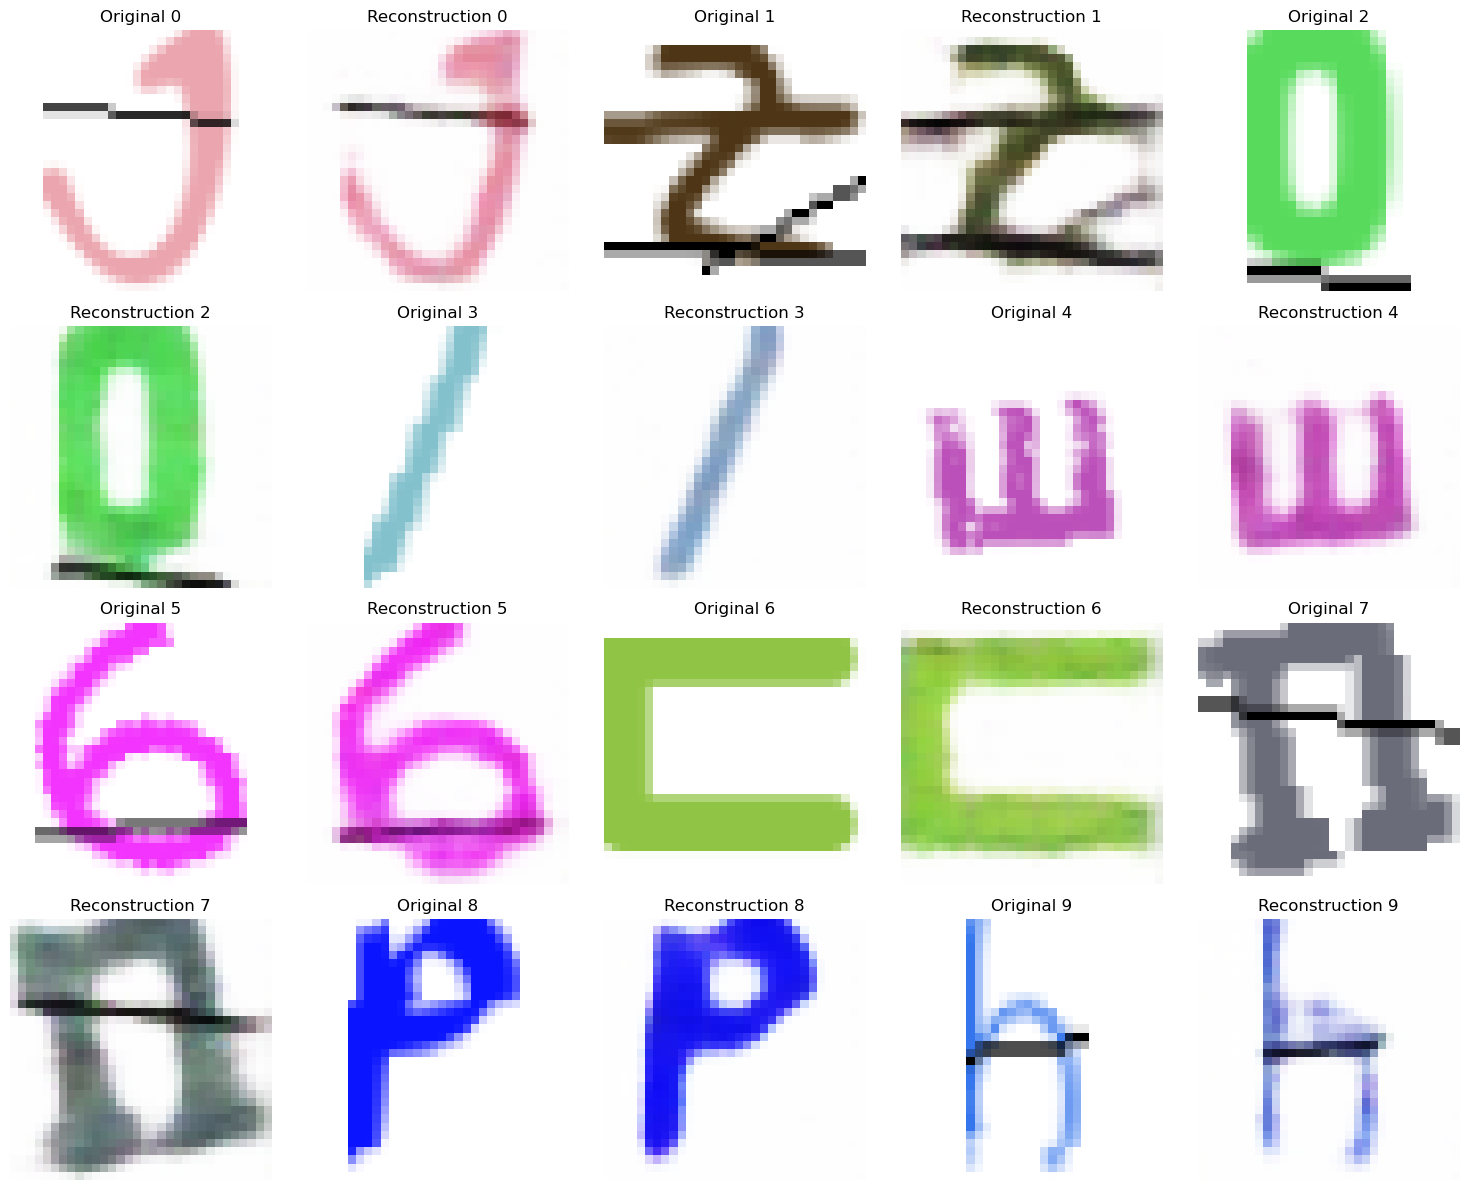

In [27]:
# Visualization
autoencoder.eval()
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

inputs, _ = next(iter(val_loader))
inputs = inputs.to(device)
with torch.no_grad():
    reconstructed = autoencoder(inputs).cpu()

inputs_np = inputs.cpu().permute(0, 2, 3, 1).numpy()
reconstructed_np = reconstructed.permute(0, 2, 3, 1).numpy()

for i in range(10):
    # Original
    axes[i*2].imshow(inputs_np[i])
    axes[i*2].set_title(f"Original {i}")
    axes[i*2].axis('off')
    # Reconstruction
    axes[i*2 + 1].imshow(reconstructed_np[i])
    axes[i*2 + 1].set_title(f"Reconstruction {i}")
    axes[i*2 + 1].axis('off')

plt.tight_layout()
plt.show()

## Classifier Architecture

In [28]:
class EncoderClassifier(nn.Module):
    def __init__(self, pretrained_encoder, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):
        super(EncoderClassifier, self).__init__()
        self.encoder = pretrained_encoder
        
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


In [29]:
#
# -----------------
# 这是一个新单元格（插入到 Cell 26 和 27 之间）
# -----------------
#
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# 1. 定义自定义数据集类
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(image)
        return image, label


train_transforms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor() 
])


val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])



ft_train_dataset = CustomImageDataset(X_train_split, y_train_split, transform=train_transforms)
ft_val_dataset = CustomImageDataset(X_val, y_val, transform=val_transforms)
ft_test_dataset = CustomImageDataset(X_test, y_test, transform=val_transforms)


ft_train_loader = DataLoader(ft_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ft_val_loader = DataLoader(ft_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
ft_test_loader = DataLoader(ft_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✓ 增强 DataLoaders 已准备就绪！")

✓ 增强 DataLoaders 已准备就绪！


## finetune

In [30]:
# Instanziieren Sie das neue Modell
finetune_model = EncoderClassifier(pretrained_encoder).to(device)

# Definieren Sie den Loss (derselbe wie bei der Baseline)
criterion_ft = nn.CrossEntropyLoss()
# +++ NEW OPTION +++
# Set this to True to use CosineAnnealingLR, False to use ReduceLROnPlateau
USE_COSINE_SCHEDULER = True 

# Single learning rate for all parameters
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=LEARNING_RATE)

# --- Scheduler Selection ---
if USE_COSINE_SCHEDULER:
    scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_ft, T_max=NUM_EPOCHS, eta_min=1e-6 # eta_min is a good practice
    )
    print("Using CosineAnnealingLR scheduler.")
else:
    scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_ft, 'min', patience=3, factor=0.5
    )
    print("Using ReduceLROnPlateau scheduler.")

# Loss function
criterion_ft = nn.CrossEntropyLoss()

BEST_FT_MODEL_PATH = MODEL_SAVE_DIR / 'best_finetune_cnn.pth'

print("Starting Fine-Tuning-Training...")
print(f"  Shared Learning Rate: {LEARNING_RATE:.1e}\n")

start_time_ft = time.time()

history_ft = {
    'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []
}

best_val_loss_ft = float('inf')
patience_counter_ft = 0
best_epoch_ft = 0

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    finetune_model.train()
    running_loss_ft = 0.0
    correct_train_ft = 0
    total_train_ft = 0
    
    for inputs, labels in ft_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(inputs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        
        running_loss_ft += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_ft += labels.size(0)
        correct_train_ft += (predicted == labels).sum().item()
    
    epoch_loss_ft = running_loss_ft / len(train_dataset)
    epoch_acc_ft = correct_train_ft / total_train_ft
    history_ft['loss'].append(epoch_loss_ft)
    history_ft['accuracy'].append(epoch_acc_ft)
    
    # --- Validation Phase ---
    finetune_model.eval()
    running_val_loss_ft = 0.0
    correct_val_ft = 0
    total_val_ft = 0
    
    with torch.no_grad():
        for inputs, labels in ft_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = finetune_model(inputs)
            loss = criterion_ft(outputs, labels)
            
            running_val_loss_ft += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_ft += labels.size(0)
            correct_val_ft += (predicted == labels).sum().item()
            
    epoch_val_loss_ft = running_val_loss_ft / len(val_dataset)
    epoch_val_acc_ft = correct_val_ft / total_val_ft
    history_ft['val_loss'].append(epoch_val_loss_ft)
    history_ft['val_accuracy'].append(epoch_val_acc_ft)
    
    # --- Epoch End ---
    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | ' \
          f'Loss: {epoch_loss_ft:.4f} - Acc: {epoch_acc_ft:.4f} | ' \
          f'Val_Loss: {epoch_val_loss_ft:.4f} - Val_Acc: {epoch_val_acc_ft:.4f}')
    
    # --- Scheduler Step (conditional) ---
    if USE_COSINE_SCHEDULER:
        scheduler_ft.step() # Cosine scheduler steps every epoch
    else:
        scheduler_ft.step(epoch_val_loss_ft) # Plateau scheduler steps on metric
    
    # Early stopping
    if epoch_val_loss_ft < best_val_loss_ft:
        best_val_loss_ft = epoch_val_loss_ft
        patience_counter_ft = 0
        best_epoch_ft = epoch
        torch.save(finetune_model.state_dict(), BEST_FT_MODEL_PATH)
    else:
        patience_counter_ft += 1
        if patience_counter_ft >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {patience_counter_ft} epochs with no improvement.")
            break

training_time_ft = time.time() - start_time_ft

print(f"Restoring model weights from the best epoch: {best_epoch_ft + 1}")
finetune_model.load_state_dict(torch.load(BEST_FT_MODEL_PATH))

print(f"\nFine-Tuning training completed in {training_time_ft:.1f} seconds ({training_time_ft/60:.1f} minutes)")
print(f"  Best Validation Loss: {best_val_loss_ft:.4f}")

Using CosineAnnealingLR scheduler.
Starting Fine-Tuning-Training...
  Shared Learning Rate: 1.0e-03

Epoch 1/20 | Loss: 2.7490 - Acc: 0.2850 | Val_Loss: 1.6074 - Val_Acc: 0.5306
Epoch 2/20 | Loss: 1.6916 - Acc: 0.5047 | Val_Loss: 1.1839 - Val_Acc: 0.6534
Epoch 3/20 | Loss: 1.4591 - Acc: 0.5682 | Val_Loss: 1.1067 - Val_Acc: 0.6858
Epoch 4/20 | Loss: 1.3223 - Acc: 0.6065 | Val_Loss: 1.0859 - Val_Acc: 0.6962
Epoch 5/20 | Loss: 1.2404 - Acc: 0.6282 | Val_Loss: 0.9525 - Val_Acc: 0.7202
Epoch 6/20 | Loss: 1.1640 - Acc: 0.6496 | Val_Loss: 0.8837 - Val_Acc: 0.7431
Epoch 7/20 | Loss: 1.1113 - Acc: 0.6632 | Val_Loss: 0.8665 - Val_Acc: 0.7485
Epoch 8/20 | Loss: 1.0519 - Acc: 0.6797 | Val_Loss: 0.8520 - Val_Acc: 0.7598
Epoch 9/20 | Loss: 1.0110 - Acc: 0.6925 | Val_Loss: 0.8023 - Val_Acc: 0.7561
Epoch 10/20 | Loss: 0.9697 - Acc: 0.7035 | Val_Loss: 0.8247 - Val_Acc: 0.7548
Epoch 11/20 | Loss: 0.9324 - Acc: 0.7104 | Val_Loss: 0.7671 - Val_Acc: 0.7792
Epoch 12/20 | Loss: 0.9006 - Acc: 0.7221 | Val_Los

In [31]:
finetune_model.eval()
test_loss_val_ft = 0.0
correct_test_ft = 0
total_test_ft = 0

y_pred_ft_list = []
y_pred_proba_ft_list = []

with torch.no_grad():
    for inputs, labels in ft_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = finetune_model(inputs)
        loss = criterion_ft(outputs, labels)
        
        test_loss_val_ft += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_ft += labels.size(0)
        correct_test_ft += (predicted == labels).sum().item()
        
        y_pred_ft_list.append(predicted.cpu().numpy())
        y_pred_proba_ft_list.append(torch.softmax(outputs, dim=1).cpu().numpy())

test_loss_ft = test_loss_val_ft / len(test_dataset)
test_accuracy_ft = correct_test_ft / total_test_ft

y_pred_ft = np.concatenate(y_pred_ft_list)
y_pred_proba_ft = np.concatenate(y_pred_proba_ft_list)

string_accuracy_ft, correct_captchas_ft, total_captchas_ft, captcha_predictions_ft, captcha_ground_truth_ft, stats_ft = \
    calculate_string_accuracy(y_pred_ft, y_test, test_filenames, IDX_TO_CHAR)

print(f"\n{'='*60}")
print(f"ACCURACY SUMMARY (FINE-TUNED MODEL)")
print(f"{'='*60}")
print(f"Character Level:")
print(f"  Loss: {test_loss_ft:.4f} | Accuracy: {test_accuracy_ft:.4f} ({test_accuracy_ft*100:.2f}%)")
print(f"  Correct: {correct_test_ft:,}/{total_test_ft:,} characters")
print(f"\nString Level (Complete CAPTCHA):")
print(f"  Accuracy: {string_accuracy_ft:.4f} ({string_accuracy_ft*100:.2f}%)")
print(f"  Correct: {correct_captchas_ft:,}/{total_captchas_ft:,} CAPTCHAs")
print(f"  Avg chars/CAPTCHA: {stats_ft['avg_chars_per_captcha']:.2f}")
print(f"{'='*60}")


ACCURACY SUMMARY (FINE-TUNED MODEL)
Character Level:
  Loss: 0.4423 | Accuracy: 0.8636 (86.36%)
  Correct: 8,014/9,280 characters

String Level (Complete CAPTCHA):
  Accuracy: 0.5064 (50.64%)
  Correct: 789/1,558 CAPTCHAs
  Avg chars/CAPTCHA: 5.96


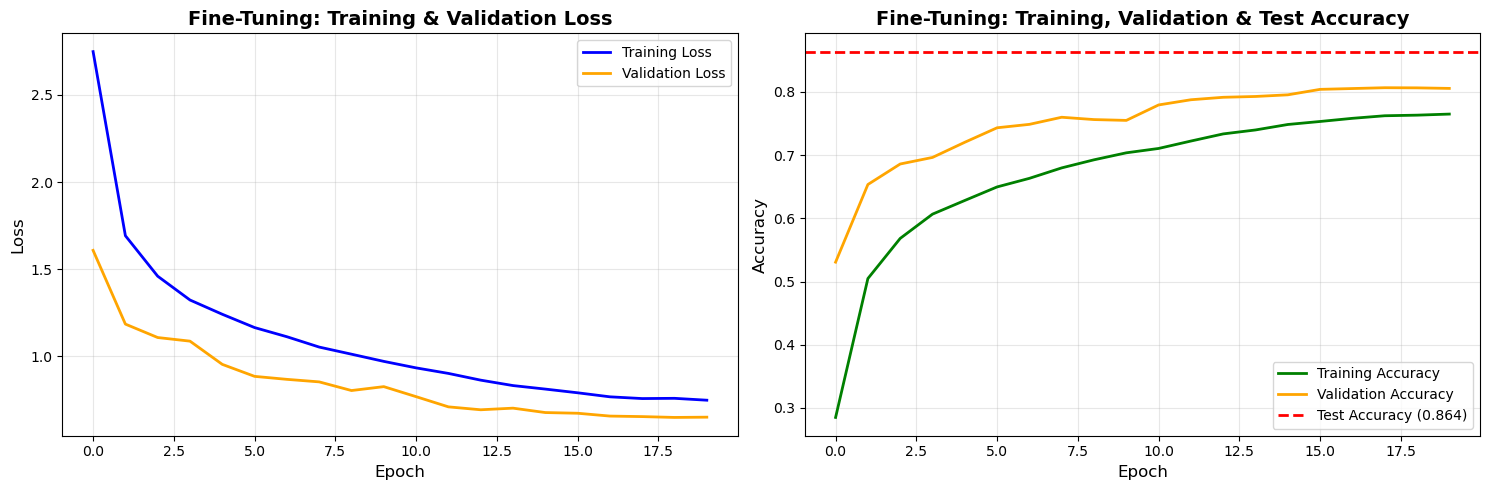


OVERFITTING ANALYSIS (FINE-TUNED MODEL)
Train: 0.7648 (76.48%)
Val:   0.8054 (80.54%)
Test:  0.8636 (86.36%)

Train-Val Gap:  -0.0406 (-4.06%)
Val-Test Gap:   -0.0582 (-5.82%)


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history_ft['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history_ft['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_title('Fine-Tuning: Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history_ft['accuracy'], label='Training Accuracy', linewidth=2, color='green')
ax2.plot(history_ft['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
ax2.axhline(y=test_accuracy_ft, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_accuracy_ft:.3f})')
ax2.set_title('Fine-Tuning: Training, Validation & Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overfitting-Analyse
train_acc_final_ft = history_ft['accuracy'][-1]
val_acc_final_ft = history_ft['val_accuracy'][-1]
train_val_gap_ft = train_acc_final_ft - val_acc_final_ft
val_test_gap_ft = val_acc_final_ft - test_accuracy_ft

print(f"\n{'='*60}")
print(f"OVERFITTING ANALYSIS (FINE-TUNED MODEL)")
print(f"{'='*60}")
print(f"Train: {train_acc_final_ft:.4f} ({train_acc_final_ft*100:.2f}%)")
print(f"Val:   {val_acc_final_ft:.4f} ({val_acc_final_ft*100:.2f}%)")
print(f"Test:  {test_accuracy_ft:.4f} ({test_accuracy_ft*100:.2f}%)")
print(f"\nTrain-Val Gap:  {train_val_gap_ft:.4f} ({train_val_gap_ft*100:.2f}%)")
print(f"Val-Test Gap:   {val_test_gap_ft:.4f} ({val_test_gap_ft*100:.2f}%)")
print(f"{'='*60}")

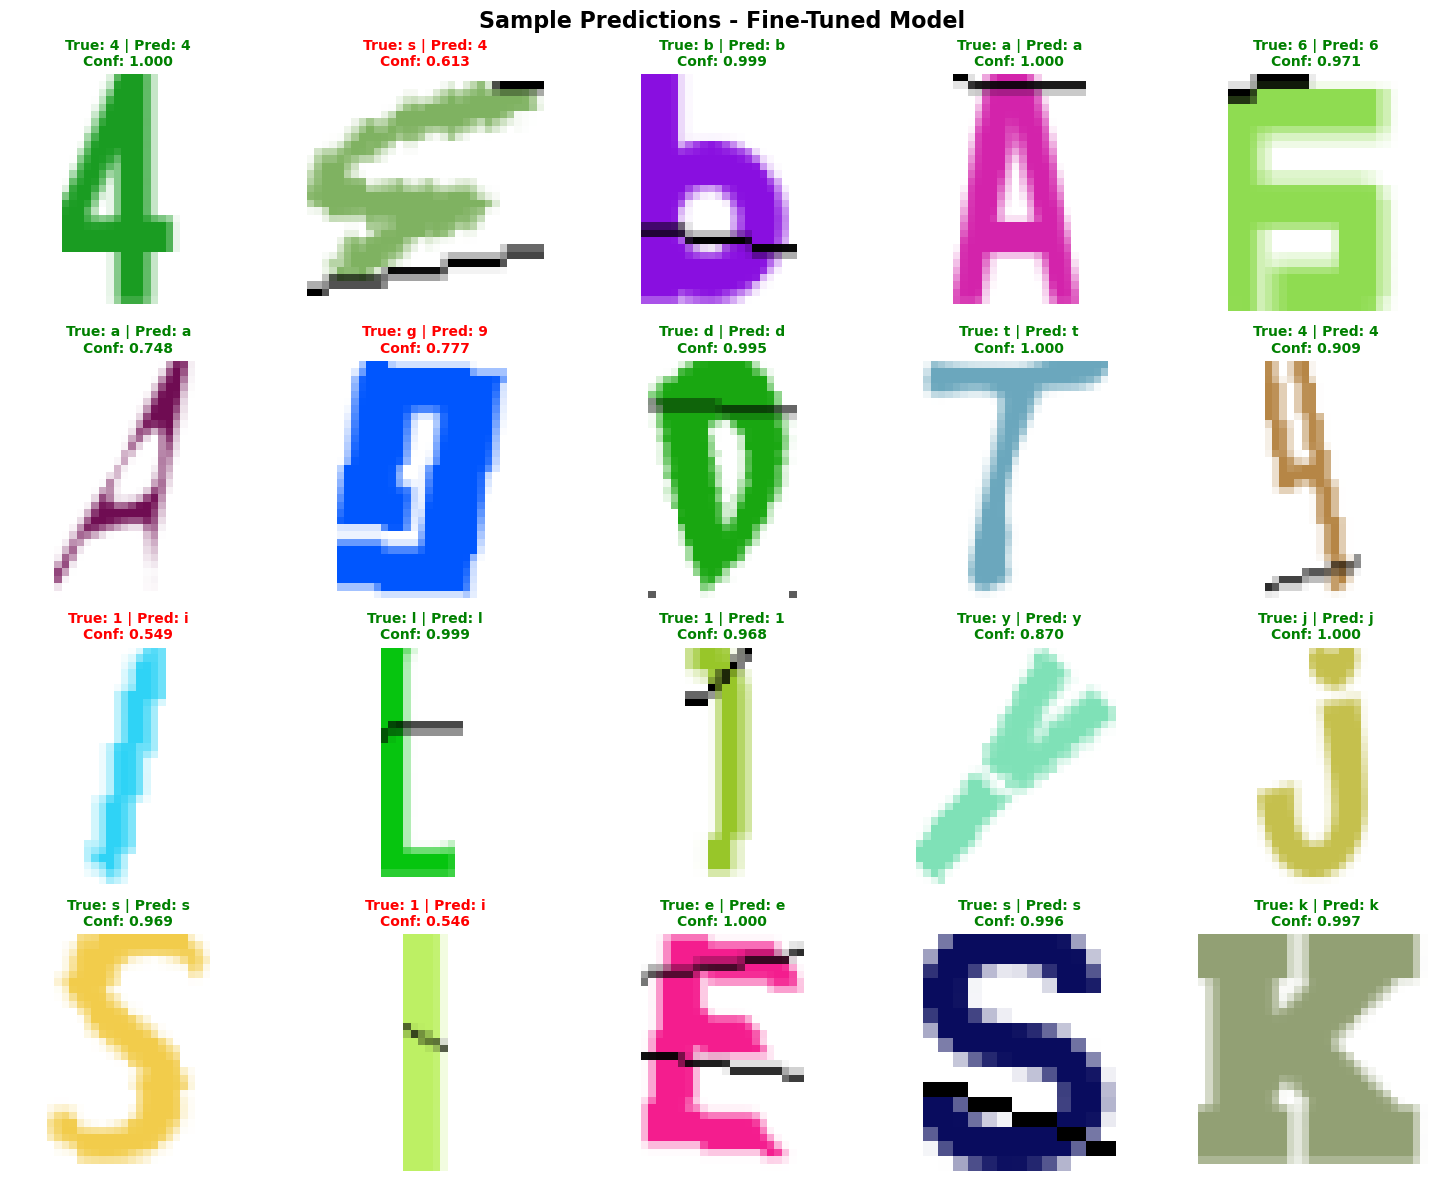

In [33]:
# Sample Predictions (Fine-Tuning)
num_samples = 20
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_ft[idx] 
    confidence = y_pred_proba_ft[idx][pred_label] 
    
    true_char = IDX_TO_CHAR[true_label]
    pred_char = IDX_TO_CHAR[pred_label]
    color = 'green' if true_label == pred_label else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_char} | Pred: {pred_char}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions - Fine-Tuned Model', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Baseline

Train: 0.8491 (84.91%)
Val:   0.7825 (78.25%)
Test:  0.8472 (84.72%)


+reconstruction

Train: 0.9081 (90.81%)
Val:   0.8022 (80.22%)
Test:  0.8407 (84.07%)

significant improvement on training set but become worse on test set. This indicate the network overfit training set. So we use data augmentation.


+reconstruction + data augment(RandomAffine, ColorJitter)

Train: 0.8080 (80.80%)
Val:   0.8288 (82.88%)
Test:  0.8833 (88.33%)

